# Setup

In [1]:
from sf_quant.data.factors import load_factors, get_factor_names
import polars as pl
import datetime as dt
import numpy as np

import matplotlib.pyplot as plt

/home/boobus/projects/factor_momentum/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-01 13:03:19,881	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [87]:
start = dt.date(2001,1,1)
end = dt.date(2020,1,1)
factors = [fac for fac in get_factor_names(type='style') if not fac in ['USSLOWL_MOMENTUM','USSLOWL_LTREVRSL']]

daily = load_factors(start=start, end=end, factors=factors)
daily = daily.unpivot(index='date', variable_name='factor', value_name='ret')
daily.describe()

statistic,date,factor,ret
str,str,str,f64
"""count""","""66906""","""66906""",66906.0
"""null_count""","""0""","""0""",0.0
"""mean""","""2010-07-04 06:25:41.242000""",null,0.000794
"""std""",null,null,0.184056
"""min""","""2001-01-02""","""USSLOWL_BETA""",-3.494329
"""25%""","""2005-10-04""",null,-0.065525
"""50%""","""2010-07-06""",null,0.001672
"""75%""","""2015-04-06""",null,0.069566
"""max""","""2019-12-31""","""USSLOWL_VALUE""",5.513288


In [88]:
monthly = (daily.with_columns(
    pl.col('date').dt.truncate('1mo').alias('month')
)
.group_by(['factor', 'month']).agg(
    ((np.log(1 + pl.col('ret')*.01).sum()
    .exp() - 1)*100)
    .alias('ret')
)
.sort(['factor', 'month'])
.with_columns(
    pl.col('ret').shift(1).over('factor').alias('lag_ret')
)
)

monthly.describe()

statistic,factor,month,ret,lag_ret
str,str,str,f64,f64
"""count""","""3192""","""3192""",3192.0,3178.0
"""null_count""","""0""","""0""",0.0,14.0
"""mean""",null,"""2010-06-16 13:41:03.157000""",0.016032,0.015859
"""std""",null,null,0.763331,0.764399
"""min""","""USSLOWL_BETA""","""2001-01-01""",-9.63708,-9.63708
"""25%""",null,"""2005-10-01""",-0.296606,-0.297743
"""50%""",null,"""2010-07-01""",0.034941,0.034589
"""75%""",null,"""2015-03-01""",0.35885,0.359041
"""max""","""USSLOWL_VALUE""","""2019-12-01""",5.726205,5.726205


# Discrete Signal

In [89]:
monthly_ls = (monthly.with_columns(
    pl.col("lag_ret").rank('dense').over('month').alias('rank'),
    pl.col('lag_ret').count().over('month').alias('count')
)
.with_columns(
    pl.when(pl.col('rank') < pl.col('count')*0.5)
    .then(-1)
    .otherwise(1)
    .alias('signal')
)
)
monthly_ls

factor,month,ret,lag_ret,rank,count,signal
str,date,f64,f64,u32,u32,i32
"""USSLOWL_BETA""",2001-01-01,2.392851,null,null,0,1
"""USSLOWL_BETA""",2001-02-01,-9.63708,2.392851,13,14,1
"""USSLOWL_BETA""",2001-03-01,-3.855528,-9.63708,1,14,-1
"""USSLOWL_BETA""",2001-04-01,5.726205,-3.855528,1,14,-1
"""USSLOWL_BETA""",2001-05-01,-1.392299,5.726205,14,14,1
…,…,…,…,…,…,…
"""USSLOWL_VALUE""",2019-08-01,-0.753603,0.652968,12,14,1
"""USSLOWL_VALUE""",2019-09-01,0.677983,-0.753603,4,14,-1
"""USSLOWL_VALUE""",2019-10-01,-0.049016,0.677983,13,14,1


In [90]:
port_ls = (monthly_ls.group_by(['month', 'signal'])
        .agg(pl.col('ret').mean().alias('mean_ret'))
        .sort(['signal', 'month'])
        .pivot(on='signal', index='month', values='mean_ret')
        .drop_nulls()
        .with_columns(
    (pl.col('1') - pl.col('-1')).alias('L_S')
    )
)
port_ls

month,-1,1,L_S
date,f64,f64,f64
2001-02-01,-0.175415,-1.073438,-0.898023
2001-03-01,-1.34068,0.4266,1.76728
2001-04-01,2.083098,-0.230573,-2.313671
2001-05-01,-0.308392,-0.147242,0.16115
2001-06-01,-0.463395,0.57002,1.033415
…,…,…,…
2019-08-01,-0.654889,-0.105297,0.549592
2019-09-01,-0.028772,0.130027,0.158799
2019-10-01,0.111346,-0.02737,-0.138716


[]

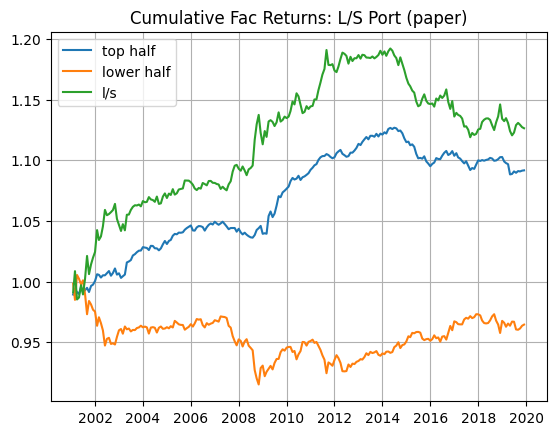

In [95]:
x = port_ls['month']
y_1 = (port_ls['1']*.01 + 1).cum_prod()
y_2 = (port_ls['-1']*.01 + 1).cum_prod()
y_3 = (port_ls['L_S']*.01 + 1).cum_prod()

plt.title('Cumulative Fac Returns: L/S Port (paper)')
plt.plot(x, y_1, label='top half')
plt.plot(x, y_2, label='lower half')
plt.plot(x, y_3, label='l/s')
plt.legend()
plt.grid(True)
plt.plot()

In [9]:
annual_ret =  port_ls['L_S'].mean() * 12
annual_vol = (port_ls['L_S']+1).std() * np.sqrt(12)
sharpe = annual_ret / annual_vol

print(
    f'Annual Return: {annual_ret:.2f}% \n'
    f'Annual Vol: {annual_vol:.2f}% \n'
    f'Sharpe: {sharpe:.2f}'
)


Annual Return: 0.65% 
Annual Vol: 1.87% 
Sharpe: 0.35


# Z-scored signal

In [10]:
monthly_z = (monthly.with_columns(
    (pl.col('lag_ret') - pl.col('lag_ret').mean().over('month') / pl.col('lag_ret').std().over('month')).alias('signal')
)
.with_columns(
    (pl.col('signal')/pl.col('signal').abs().sum().over('month')).alias('weights')
)
.with_columns(
    (pl.col('weights') * pl.col('ret')).alias('port_ret')
)
)

monthly_z

factor,month,ret,lag_ret,rank,count,signal,weights,port_ret
str,date,f64,f64,u32,u32,f64,f64,f64
"""USSLOWL_BETA""",2001-01-01,2.392851,null,null,0,null,null,null
"""USSLOWL_BETA""",2001-02-01,-9.63708,2.392851,13,14,2.363298,0.120261,-1.158962
"""USSLOWL_BETA""",2001-03-01,-3.855528,-9.63708,1,14,-9.401037,-0.413692,1.595
"""USSLOWL_BETA""",2001-04-01,5.726205,-3.855528,1,14,-3.626314,-0.294817,-1.688185
"""USSLOWL_BETA""",2001-05-01,-1.392299,5.726205,14,14,5.316171,0.273532,-0.380839
…,…,…,…,…,…,…,…,…
"""USSLOWL_VALUE""",2019-08-01,-0.753603,0.652968,12,14,0.368879,0.076372,-0.057554
"""USSLOWL_VALUE""",2019-09-01,0.677983,-0.753603,4,14,-0.432066,-0.040196,-0.027252
"""USSLOWL_VALUE""",2019-10-01,-0.049016,0.677983,13,14,0.58941,0.083903,-0.004113


In [11]:
port_z = (monthly_z.group_by('month').agg(
    pl.col('port_ret').sum().alias('ret')
).sort('month')
)
port_z


month,ret
date,f64
2001-01-01,0.0
2001-02-01,-1.449698
2001-03-01,2.170142
2001-04-01,-1.757003
2001-05-01,-0.213674
…,…
2019-08-01,0.407628
2019-09-01,0.007968
2019-10-01,-0.079269


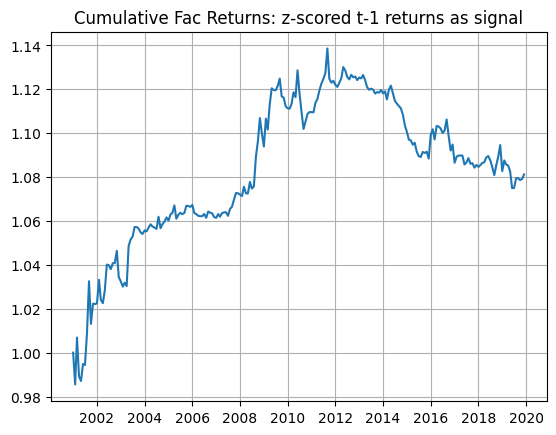

In [58]:
x = port_z['month']
y = (port_z['ret']*.01 +1).cum_prod()

plt.title('Cumulative Fac Returns: z-scored t-1 returns as signal')
plt.plot(x, y)
plt.grid(True)
plt.show()

In [25]:
annual_ret =  port_z['ret'].mean() * 12
annual_vol = port_z['ret'].std() * np.sqrt(12)
sharpe = annual_ret / annual_vol

print(
    f'Annual Return: {annual_ret:.2f}% \n'
    f'Annual Vol: {annual_vol:.2f}% \n'
    f'Sharpe: {sharpe:.2f}'
)


Annual Return: 0.43% 
Annual Vol: 1.73% 
Sharpe: 0.25


# t-12 to t-2 signal

In [47]:
monthly_12 = (monthly.with_columns(
    (np.log(pl.col('lag_ret')*.01+1))
    .shift(2)
    .rolling_sum(10)
    .alias('signal')
)
.drop_nulls()
)

In [48]:
port_12 = (monthly_12.with_columns(
    (pl.col('signal') / pl.col('signal').abs().sum().over('month')).alias('weight')
)
.with_columns(
    (pl.col('weight')*pl.col('ret')).alias('port_ret')
)
.group_by('month').agg(
    pl.col('port_ret').sum().alias('ret')
)
.sort('month')
)

port_12 

month,ret
date,f64
2001-02-01,0.4296
2002-01-01,0.645395
2002-02-01,1.386363
2002-03-01,0.020655
2002-04-01,0.831736
…,…
2019-08-01,1.276631
2019-09-01,0.190749
2019-10-01,-0.071923


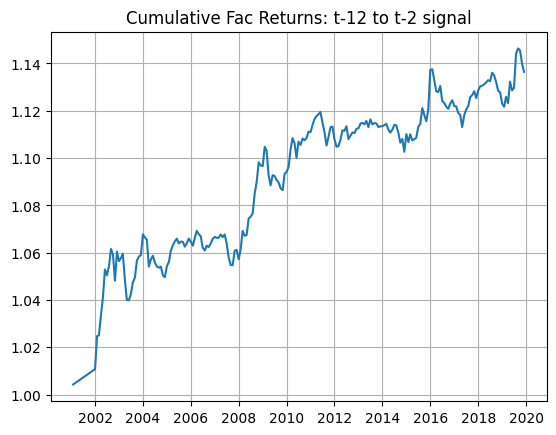

In [93]:
x = port_12['month']
y = (port_12['ret']*.01+1).cum_prod()

plt.title('Cumulative Fac Returns: t-12 to t-2 signal')
plt.plot(x, y)
plt.grid(True)
plt.show()

In [94]:
annual_ret =  port_12['ret'].mean() * 12
annual_vol = port_12['ret'].std() * np.sqrt(12)
sharpe = annual_ret / annual_vol

print(
    f'Annual Return: {annual_ret:.2f}% \n'
    f'Annual Vol: {annual_vol:.2f}% \n'
    f'Sharpe: {sharpe:.2f}'
)

Annual Return: 0.72% 
Annual Vol: 1.35% 
Sharpe: 0.53


In [51]:
monthly.write_parquet('~/temp/factor_signals-ls.parquet')
monthly_z.write_parquet('~/temp/factor_signals-z-score.parquet')
monthly_12.write_parquet('~/temp/factor_signals-lookback.parquet')

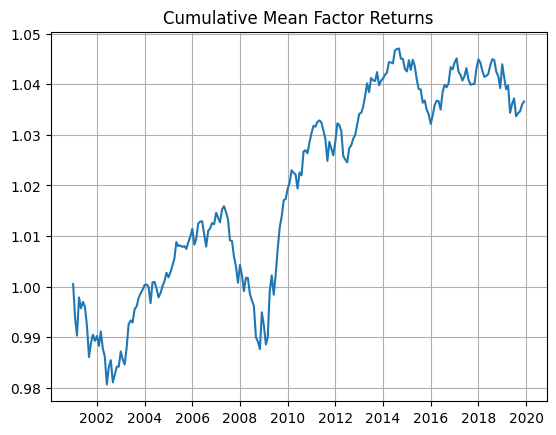

In [92]:
port_sum = (monthly.group_by('month').agg(pl.col('ret').mean()).sort('month'))

plt.title('Cumulative Mean Factor Returns')
plt.plot(port_sum['month'], (port_sum['ret']*.01+1).cum_prod())
plt.grid(True)
plt.show()